Forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.
## Data fields
- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., -   October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

#REQUIRED PACKAGES

- numpy = "*"
- pandas = "*"
- scikit-learn = "*"
- jupyter = "*"
- matplotlib = "*"
- nb-black = "*"
- tqdm = "*"
- lightgbm = "*"

In [1]:
# debugging and formatter
from IPython.core.debugger import set_trace

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm_notebook
import pickle

plt.style.use(style="seaborn")
%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
from os import listdir
from os.path import isfile, join

loc = os.path.abspath("")
data_loc = f"{loc}/data"
sales_train = pd.read_csv(f"{data_loc}/sales_train.csv")
sales_test = pd.read_csv(f"{data_loc}/test.csv")
sample = pd.read_csv(f"{data_loc}/sample_submission.csv")
items = pd.read_csv(f"{data_loc}/items.csv")
categories = pd.read_csv(f"{data_loc}/item_categories.csv")
shops = pd.read_csv(f"{data_loc}/shops.csv")

<IPython.core.display.Javascript object>

Get the shape of item_cnt_day and check for possible outliers

In [4]:
print(sales_train.shape)
print(sales_train.item_cnt_day.min())
print(sales_train.item_cnt_day.max())

(2935849, 6)
-22.0
2169.0


<IPython.core.display.Javascript object>

(array([2.93581e+06, 2.40000e+01, 1.10000e+01, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ -22. ,  197.1,  416.2,  635.3,  854.4, 1073.5, 1292.6, 1511.7,
        1730.8, 1949.9, 2169. ]),
 <a list of 10 Patch objects>)

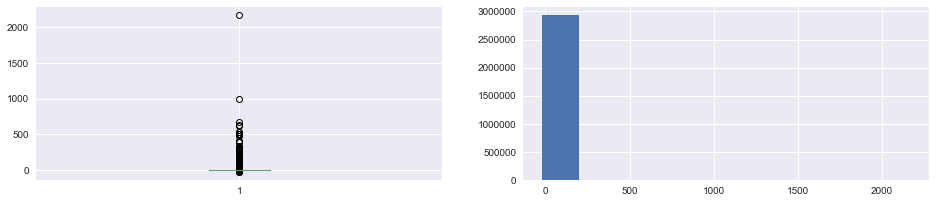

<IPython.core.display.Javascript object>

In [5]:
f = plt.figure(1, figsize=(16, 7))
ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2)
ax1.boxplot(sales_train.item_cnt_day)
ax2.hist(sales_train.item_cnt_day, bins=10)

There seem to be some outliers at 2000 and 1000 mark, let's check them out Zoom in first

(array([115.,  16.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 101. ,  307.8,  514.6,  721.4,  928.2, 1135. , 1341.8, 1548.6,
        1755.4, 1962.2, 2169. ]),
 <a list of 10 Patch objects>)

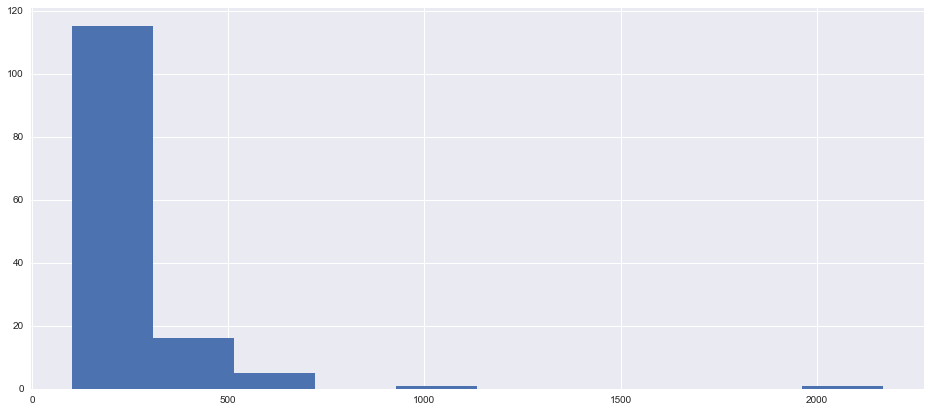

<IPython.core.display.Javascript object>

In [6]:
plt.figure(1, figsize=(16, 7))
plt.hist(sales_train.item_cnt_day[sales_train.item_cnt_day > 100], bins=10)

Check for nulls and nas.

In [7]:
print(sales_train.isnull().values.any())
print(sales_train.isna().values.any())

False
False


<IPython.core.display.Javascript object>

Merge sales data and items.

In [8]:
sales_train = pd.merge(sales_train, items, on="item_id", how="left")
sales_train = sales_train.drop("item_name", axis=1)
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

   item_category_id  
0                37  
1                58  
2                58  
3                58  
4                56

<IPython.core.display.Javascript object>

Create a dataframe of all date_block_num, store and item combinations.

In the months where we don't have data for an item - store combination, the machine learning algorithm needs to be specifically told that the sales is zero.


In [9]:
index_cols = ["shop_id", "item_id", "date_block_num"]

<IPython.core.display.Javascript object>

In [10]:
grid = []
for block_num in sales_train["date_block_num"].unique():
    cur_shops = sales_train.loc[
        sales_train["date_block_num"] == block_num, "shop_id"
    ].unique()
    cur_items = sales_train.loc[
        sales_train["date_block_num"] == block_num, "item_id"
    ].unique()
    grid.append(
        np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype="int32")
    )
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

<IPython.core.display.Javascript object>

In [11]:
grid.head()

shop_id  item_id  date_block_num
0       59    22154               0
1       59     2552               0
2       59     2554               0
3       59     2555               0
4       59     2564               0

<IPython.core.display.Javascript object>

Group the transactions and apply the aggreated functions where sum of item_cnt_day will be the target variable.

In [12]:
mean_sales_train = (
    sales_train.groupby(["date_block_num", "shop_id", "item_id"])
    .agg({"item_cnt_day": "sum", "item_price": np.mean})
    .reset_index()
)

<IPython.core.display.Javascript object>

In [13]:
mean_sales_train = pd.merge(
    grid, mean_sales_train, on=["date_block_num", "shop_id", "item_id"], how="left"
).fillna(0)

<IPython.core.display.Javascript object>

In [14]:
mean_sales_train = pd.merge(mean_sales_train, items, on="item_id", how="left")

<IPython.core.display.Javascript object>

In [15]:
mean_sales_train.head(5)

shop_id  item_id  date_block_num  item_cnt_day  item_price  \
0       59    22154               0           1.0       999.0   
1       59     2552               0           0.0         0.0   
2       59     2554               0           0.0         0.0   
3       59     2555               0           0.0         0.0   
4       59     2564               0           0.0         0.0   

                                           item_name  item_category_id  
0                                  ЯВЛЕНИЕ 2012 (BD)                37  
1           DEEP PURPLE  The House Of Blue Light  LP                58  
2           DEEP PURPLE  Who Do You Think We Are  LP                58  
3            DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56  
4  DEEP PURPLE Perihelion: Live In Concert DVD (К...                59

<IPython.core.display.Javascript object>

Create mean encodings.

In [16]:
for type_id in ["item_id", "shop_id", "item_category_id"]:
    for column_id, aggregator, aggtype in [
        ("item_price", np.mean, "avg"),
        ("item_cnt_day", np.sum, "sum"),
        ("item_cnt_day", np.mean, "avg"),
    ]:

        mean_df = (
            sales_train.groupby([type_id, "date_block_num"])
            .aggregate(aggregator)
            .reset_index()[[column_id, type_id, "date_block_num"]]
        )
        mean_df.columns = [
            type_id + "_" + aggtype + "_" + column_id,
            type_id,
            "date_block_num",
        ]
        mean_sales_train = pd.merge(
            mean_sales_train, mean_df, on=["date_block_num", type_id], how="left"
        )

<IPython.core.display.Javascript object>

In [17]:
mean_sales_train.head(5)

shop_id  item_id  date_block_num  item_cnt_day  item_price  \
0       59    22154               0           1.0       999.0   
1       59     2552               0           0.0         0.0   
2       59     2554               0           0.0         0.0   
3       59     2555               0           0.0         0.0   
4       59     2564               0           0.0         0.0   

                                           item_name  item_category_id  \
0                                  ЯВЛЕНИЕ 2012 (BD)                37   
1           DEEP PURPLE  The House Of Blue Light  LP                58   
2           DEEP PURPLE  Who Do You Think We Are  LP                58   
3            DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   
4  DEEP PURPLE Perihelion: Live In Concert DVD (К...                59   

   item_id_avg_item_price  item_id_sum_item_cnt_day  item_id_avg_item_cnt_day  \
0                  999.00                      18.0                       1.0   
1                  899.00                       0.0                       0.0   
2                 1709.05                       1.0                       1.0   
3                 1098.85                       2.0                       1.0   
4                  327.60                       5.0                       1.0   

   shop_id_avg_item_price  shop_id_sum_item_cnt_day  shop_id_avg_item_cnt_day  \
0              820.174553                    2017.0                  1.092041   
1              820.174553                    2017.0                  1.092041   
2              820.174553                    2017.0                  1.092041   
3              820.174553                    2017.0                  1.092041   
4              820.174553                    2017.0                  1.092041   

   item_category_id_avg_item_price  item_category_id_sum_item_cnt_day  \
0                       465.036007                             6094.0   
1                      1401.858108                              287.0   
2                      1401.858108                              287.0   
3                       867.446992                              268.0   
4                       443.330014                              701.0   

   item_category_id_avg_item_cnt_day  
0                           1.053414  
1                           0.969595  
2                           0.969595  
3                           1.007519  
4                           0.990113

<IPython.core.display.Javascript object>

The mean encodings cannot be used with predict as we don't know the target variable. 

I'll create lags for all these mean encodings and will use these lagged values (mean encoding at t-1, t-2 ..) to predict.

In [18]:
lag_variables = list(mean_sales_train.columns[7:]) + ["item_cnt_day"]
lags = [1, 2, 3, 6, 12]

for lag in tqdm_notebook(lags):

    sales_new_df = mean_sales_train.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[
        ["date_block_num", "shop_id", "item_id"] + lag_variables
    ]
    sales_new_df.columns = ["date_block_num", "shop_id", "item_id"] + [
        lag_feat + "_lag_" + str(lag) for lag_feat in lag_variables
    ]
    mean_sales_train = pd.merge(
        mean_sales_train,
        sales_new_df,
        on=["date_block_num", "shop_id", "item_id"],
        how="left",
    )

/Users/radufotolescu/.local/share/virtualenvs/predict-future-sales-foPFOWdH/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>

In [19]:
mean_sales_train.head(5)

shop_id  item_id  date_block_num  item_cnt_day  item_price  \
0       59    22154               0           1.0       999.0   
1       59     2552               0           0.0         0.0   
2       59     2554               0           0.0         0.0   
3       59     2555               0           0.0         0.0   
4       59     2564               0           0.0         0.0   

                                           item_name  item_category_id  \
0                                  ЯВЛЕНИЕ 2012 (BD)                37   
1           DEEP PURPLE  The House Of Blue Light  LP                58   
2           DEEP PURPLE  Who Do You Think We Are  LP                58   
3            DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   
4  DEEP PURPLE Perihelion: Live In Concert DVD (К...                59   

   item_id_avg_item_price  item_id_sum_item_cnt_day  item_id_avg_item_cnt_day  \
0                  999.00                      18.0                       1.0   
1                  899.00                       0.0                       0.0   
2                 1709.05                       1.0                       1.0   
3                 1098.85                       2.0                       1.0   
4                  327.60                       5.0                       1.0   

   ...  item_id_avg_item_price_lag_12  item_id_sum_item_cnt_day_lag_12  \
0  ...                            NaN                              NaN   
1  ...                            NaN                              NaN   
2  ...                            NaN                              NaN   
3  ...                            NaN                              NaN   
4  ...                            NaN                              NaN   

   item_id_avg_item_cnt_day_lag_12  shop_id_avg_item_price_lag_12  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   shop_id_sum_item_cnt_day_lag_12  shop_id_avg_item_cnt_day_lag_12  \
0                              NaN                              NaN   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4                              NaN                              NaN   

   item_category_id_avg_item_price_lag_12  \
0                                     NaN   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   item_category_id_sum_item_cnt_day_lag_12  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   item_category_id_avg_item_cnt_day_lag_12  item_cnt_day_lag_12  
0                                       NaN                  NaN  
1                                       NaN                  NaN  
2                                       NaN                  NaN  
3                                       NaN                  NaN  
4                                       NaN                  NaN  

[5 rows x 66 columns]

<IPython.core.display.Javascript object>

Fill nas.

In [20]:
for feat in mean_sales_train.columns:
    if "item_cnt" in feat:
        mean_sales_train[feat] = mean_sales_train[feat].fillna(0)
    elif "item_price" in feat:
        mean_sales_train[feat] = mean_sales_train[feat].fillna(
            mean_sales_train[feat].median()
        )

<IPython.core.display.Javascript object>

Drop columns that are not available at predict.

Basically all columns that are not lagged.

In [21]:
# dropping all target variables but not "item_cnt_day" cause is target
cols_to_drop = lag_variables[:-1] + [
    "item_price",
    "item_name",
]

<IPython.core.display.Javascript object>

### Train model

Using LightGBM.

In [22]:
training = mean_sales_train.drop(cols_to_drop, axis=1)

<IPython.core.display.Javascript object>

In [23]:
X_train = training.iloc[:, training.columns != "item_cnt_day"]
y_train = training.iloc[:, training.columns == "item_cnt_day"]

<IPython.core.display.Javascript object>

In [24]:
import lightgbm as lgb

lgb_params = {
    "feature_fraction": 0.75,
    "metric": "rmse",
    "nthread": 1,
    "min_data_in_leaf": 2 ** 7,
    "bagging_fraction": 0.75,
    "learning_rate": 0.03,
    "objective": "mse",
    "bagging_seed": 2 ** 7,
    "num_leaves": 2 ** 7,
    "bagging_freq": 1,
    "verbose": 0,
}

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)

/Users/radufotolescu/.local/share/virtualenvs/predict-future-sales-foPFOWdH/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


<IPython.core.display.Javascript object>

Save model.

In [27]:
with open(f"{data_loc}/model.pkl", "wb") as f:
    pickle.dump(model, f)

<IPython.core.display.Javascript object>

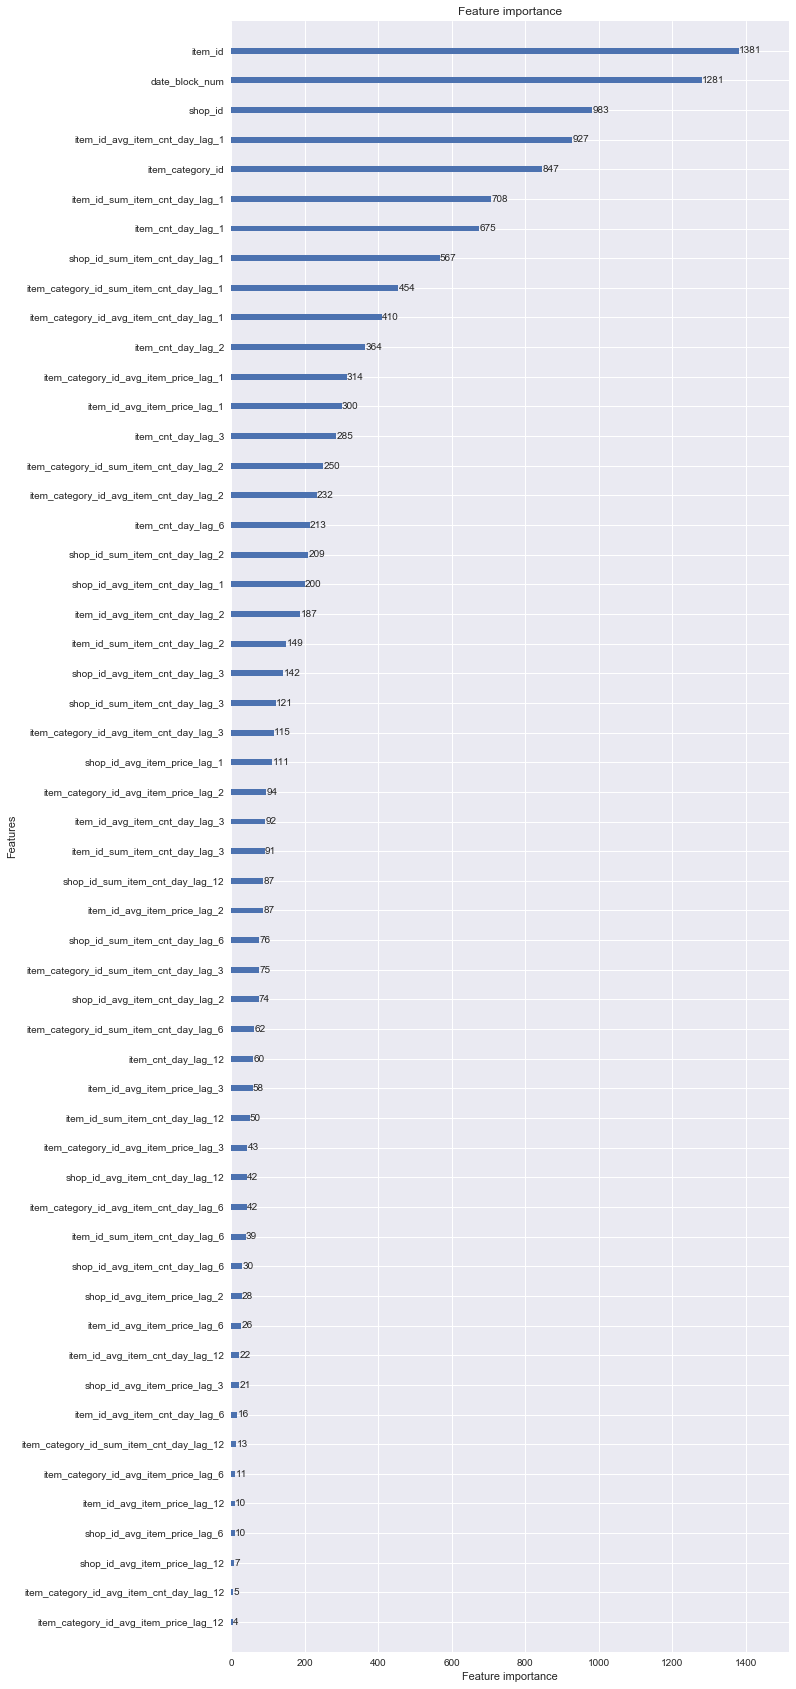

<IPython.core.display.Javascript object>

In [28]:
x = lgb.plot_importance(model)
x.figure.set_size_inches(10, 30)

Remove target feature.

In [29]:
cols = list(training.columns)
del cols[cols.index("item_cnt_day")]

<IPython.core.display.Javascript object>

### Preprocess test data


- add date_block_num = 34
- add category_id
- add lagging

In [30]:
sales_test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

<IPython.core.display.Javascript object>

In [31]:
sales_test["date_block_num"] = 34

<IPython.core.display.Javascript object>

In [32]:
test = pd.merge(sales_test, items, on="item_id", how="left")

<IPython.core.display.Javascript object>

In [33]:
test.head()

ID  shop_id  item_id  date_block_num  \
0   0        5     5037              34   
1   1        5     5320              34   
2   2        5     5233              34   
3   3        5     5232              34   
4   4        5     5268              34   

                                           item_name  item_category_id  
0                     NHL 15 [PS3, русские субтитры]                19  
1                    ONE DIRECTION  Made In The A.M.                55  
2  Need for Speed Rivals (Essentials) [PS3, русск...                19  
3  Need for Speed Rivals (Classics) [Xbox 360, ру...                23  
4               Need for Speed [PS4, русская версия]                20

<IPython.core.display.Javascript object>

In [34]:
for lag in tqdm_notebook(lags):

    sales_new_df = mean_sales_train.copy()
    sales_new_df.date_block_num += lag
    sales_new_df = sales_new_df[
        ["date_block_num", "shop_id", "item_id"] + lag_variables
    ]
    sales_new_df.columns = ["date_block_num", "shop_id", "item_id"] + [
        lag_feat + "_lag_" + str(lag) for lag_feat in lag_variables
    ]
    test = pd.merge(
        test, sales_new_df, on=["date_block_num", "shop_id", "item_id"], how="left",
    )

/Users/radufotolescu/.local/share/virtualenvs/predict-future-sales-foPFOWdH/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [35]:
test.head()

ID  shop_id  item_id  date_block_num  \
0   0        5     5037              34   
1   1        5     5320              34   
2   2        5     5233              34   
3   3        5     5232              34   
4   4        5     5268              34   

                                           item_name  item_category_id  \
0                     NHL 15 [PS3, русские субтитры]                19   
1                    ONE DIRECTION  Made In The A.M.                55   
2  Need for Speed Rivals (Essentials) [PS3, русск...                19   
3  Need for Speed Rivals (Classics) [Xbox 360, ру...                23   
4               Need for Speed [PS4, русская версия]                20   

   item_id_avg_item_price_lag_1  item_id_sum_item_cnt_day_lag_1  \
0                   1499.000000                            25.0   
1                           NaN                             NaN   
2                   1199.000000                            42.0   
3                   1190.433333                            28.0   
4                           NaN                             NaN   

   item_id_avg_item_cnt_day_lag_1  shop_id_avg_item_price_lag_1  ...  \
0                        1.000000                   1030.721934  ...   
1                             NaN                           NaN  ...   
2                        1.024390                   1030.721934  ...   
3                        0.933333                   1030.721934  ...   
4                             NaN                           NaN  ...   

   item_id_avg_item_price_lag_12  item_id_sum_item_cnt_day_lag_12  \
0                    2569.619846                             65.0   
1                            NaN                              NaN   
2                            NaN                              NaN   
3                            NaN                              NaN   
4                            NaN                              NaN   

   item_id_avg_item_cnt_day_lag_12  shop_id_avg_item_price_lag_12  \
0                              1.0                    1175.319266   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   

   shop_id_sum_item_cnt_day_lag_12  shop_id_avg_item_cnt_day_lag_12  \
0                           1445.0                         1.235043   
1                              NaN                              NaN   
2                              NaN                              NaN   
3                              NaN                              NaN   
4                              NaN                              NaN   

   item_category_id_avg_item_price_lag_12  \
0                              1800.73328   
1                                     NaN   
2                                     NaN   
3                                     NaN   
4                                     NaN   

   item_category_id_sum_item_cnt_day_lag_12  \
0                                    6134.0   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   

   item_category_id_avg_item_cnt_day_lag_12  item_cnt_day_lag_12  
0                                  1.144403                  1.0  
1                                       NaN                  NaN  
2                                       NaN                  NaN  
3                                       NaN                  NaN  
4                                       NaN                  NaN  

[5 rows x 56 columns]

<IPython.core.display.Javascript object>

Drop ID and item_name.

In [36]:
test = test.drop(["ID", "item_name"], axis=1)

<IPython.core.display.Javascript object>

Fill nas.

In [37]:
for feat in test.columns:
    if "item_cnt" in feat:
        test[feat] = test[feat].fillna(0)
    elif "item_price" in feat:
        test[feat] = test[feat].fillna(test[feat].median())

<IPython.core.display.Javascript object>

### Predict

In [38]:
preds = model.predict(test)

<IPython.core.display.Javascript object>

In [39]:
preds = preds.clip(0, 20)

<IPython.core.display.Javascript object>

In [40]:
sum(preds)

61700.93022822222

<IPython.core.display.Javascript object>

In [41]:
preds_df = pd.DataFrame({"ID": test.index, "item_cnt_month": preds})

<IPython.core.display.Javascript object>

In [42]:
preds_df.to_csv("final_submission.csv", index=False)

<IPython.core.display.Javascript object>